In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from matplotlib import pyplot as plt
import torchvision.models as models
import random
from PIL import Image
from torch.utils.data import Dataset

In [3]:
# 设置数据集路径
total_dir = "/Users/fcccasa/Downloads/R/img"

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 加载数据集
total_data = datasets.ImageFolder(total_dir, transform)

# 获取类别并按数字顺序排序
def sort_key(class_name):
    # 尝试将类别名称转换为整数，若失败则返回原字符串
    try:
        return int(class_name)  # 如果类别是数字，则按数字排序
    except ValueError:
        return class_name  # 如果类别是非数字，则按字母排序

sorted_classes = sorted(total_data.classes, key=sort_key)

# 更新 ImageFolder 的 class_to_idx 字典
total_data.class_to_idx = {cls: idx for idx, cls in enumerate(sorted_classes)}

print("Sorted Classes:", sorted_classes)

# 使用排序后的类名创建训练集和测试集索引
train_indices = []
test_indices = []

# 遍历数据集中的每个类别（文件夹）
for class_idx in range(len(sorted_classes)):
    # 获取当前类别所有图像的索引
    class_indices = [i for i, label in enumerate(total_data.targets) if label == class_idx]
    
    # 分割：前40个图像为训练集，剩下的为测试集
    train_indices.extend(class_indices[:40])
    test_indices.extend(class_indices[40:])

# 使用索引创建训练集和测试集
train_dataset = torch.utils.data.Subset(total_data, train_indices)
test_dataset = torch.utils.data.Subset(total_data, test_indices)

# 打印训练集和测试集的大小
print(f'训练集大小: {len(train_dataset)}')
print(f'测试集大小: {len(test_dataset)}')


Sorted Classes: ['-250', '-249', '-248', '-247', '-246', '-245', '-244', '-243', '-242', '-241', '-240', '-239', '-238', '-237', '-236', '-235', '-234', '-233', '-232', '-231', '-230', '-229', '-228', '-227', '-226', '-225', '-224', '-223', '-222', '-221', '-220', '-219', '-218', '-217', '-216', '-215', '-214', '-213', '-212', '-211', '-210', '-209', '-208', '-207', '-206', '-205', '-204', '-203', '-202', '-201', '-200', '-199', '-198', '-197', '-196', '-195', '-194', '-193', '-192', '-191', '-190', '-189', '-188', '-187', '-186', '-185', '-184', '-183', '-182', '-181', '-180', '-179', '-178', '-177', '-176', '-175', '-174', '-173', '-172', '-171', '-170', '-169', '-168', '-167', '-166', '-165', '-164', '-163', '-162', '-161', '-160', '-159', '-158', '-157', '-156', '-155', '-154', '-153', '-152', '-151', '-150', '-149', '-148', '-147', '-146', '-145', '-144', '-143', '-142', '-141', '-140', '-139', '-138', '-137', '-136', '-135', '-134', '-133', '-132', '-131', '-130', '-129', '-128',

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=1)


In [5]:
# 初始化
num_classes = 1

MAX_EPOCH = 20     
LR = 0.001         
log_interval = 10    # 每隔 1 个 训练批次（或 epoch）记录一次训练日志。 表示训练过程中，控制打印训练信息的频率。
val_interval = 1    # 每隔 1 个 epoch 进行一次验证集的评估。验证集的评估是为了监控模型在验证集上的表现，从而避免过拟合。
classes = 1         # 分类任务的类别数为 2。
start_epoch = -1     
lr_decay_step = 5   # 表示学习率的衰减步长。 每隔一定的 epoch（如 1）对学习率进行衰减，通常是为了使模型在后期更稳定地收敛。
                    # 可结合优化器的学习率调度策略（如 StepLR）使用。

In [6]:
device = device = torch.device("mps")
res_model = models.resnet18(pretrained=True)  # 使用预训练权重
# 获取 ResNet 的最后一层输入特征数
num_ftrs = res_model.fc.in_features  # 获取fc层的输入特征数
res_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),           # 将输入特征维度映射到4096
    nn.ReLU(),
    nn.Linear(128, 1)                    # 输出为1，进行回归预测任务
)
print(num_ftrs)
res_model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
criterion = nn.L1Loss()

In [8]:
optimizer = torch.optim.Adam(res_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=0.1)

In [9]:
train_curve = list() 
valid_curve = list()

for epoch in range(start_epoch + 1, MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    res_model.train() # 将模型切换到训练模式，启用 dropout 等操作。
    for i, data in enumerate(train_dataloader):
        # 遍历训练数据加载器，data 包含一个批次的 inputs（输入图像）和 labels（对应的标签）。

        # forward
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = res_model(inputs)

        # 调整标签的形状
        labels = labels.view(-1, 1)  # 确保标签的形状与输出一致

        # backward
        optimizer.zero_grad()
        # 清空上一批次的梯度，防止累积。
        loss = criterion(outputs, labels)
        loss.backward()
        # 通过自动求导计算梯度。

        # update weights
        optimizer.step()
        # 使用优化器根据计算出的梯度更新模型参数。

        # 打印训练信息
        loss_mean += loss.item()        # 获取当前批次的损失值。
        train_curve.append(loss.item()) # 将当前批次的损失值记录到 train_curve。
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training: Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f}".format(
                epoch, MAX_EPOCH, i+1, len(train_dataloader), loss_mean))
            loss_mean = 0.

    scheduler.step()  # 更新学习率 调用学习率调度器，根据设置调整当前学习率（如按一定步长下降）。

    # validate the model
    if (epoch+1) % val_interval == 0:

        correct_val = 0.
        total_val = 0.
        loss_val = 0.
        res_model.eval() 
        
        # 禁用自动求导，减少内存占用，加速计算。
        with torch.no_grad():
            for j, data in enumerate(test_dataloader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = res_model(inputs)
               
                # 调整标签的形状
                labels = labels.view(-1, 1)  # 确保标签的形状与输出一致

                loss = criterion(outputs, labels)

                loss_val += loss.item()

            loss_val_mean = loss_val / len(test_dataloader)
            valid_curve.append(loss_val_mean)
            print("Valid: Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f}".format(
                epoch, MAX_EPOCH, j+1, len(test_dataloader), loss_val_mean))

        res_model.train()  # 将模型切换回训练模式


Training: Epoch[000/020] Iteration[010/501] Loss: 237.1185
Training: Epoch[000/020] Iteration[020/501] Loss: 226.0619
Training: Epoch[000/020] Iteration[030/501] Loss: 182.5959
Training: Epoch[000/020] Iteration[040/501] Loss: 137.0634
Training: Epoch[000/020] Iteration[050/501] Loss: 81.6169
Training: Epoch[000/020] Iteration[060/501] Loss: 47.2030
Training: Epoch[000/020] Iteration[070/501] Loss: 46.1357
Training: Epoch[000/020] Iteration[080/501] Loss: 33.7395
Training: Epoch[000/020] Iteration[090/501] Loss: 30.8008
Training: Epoch[000/020] Iteration[100/501] Loss: 37.8186
Training: Epoch[000/020] Iteration[110/501] Loss: 37.1115
Training: Epoch[000/020] Iteration[120/501] Loss: 33.1079
Training: Epoch[000/020] Iteration[130/501] Loss: 30.4821
Training: Epoch[000/020] Iteration[140/501] Loss: 22.7706
Training: Epoch[000/020] Iteration[150/501] Loss: 28.3780
Training: Epoch[000/020] Iteration[160/501] Loss: 28.9952
Training: Epoch[000/020] Iteration[170/501] Loss: 26.1499
Training: 

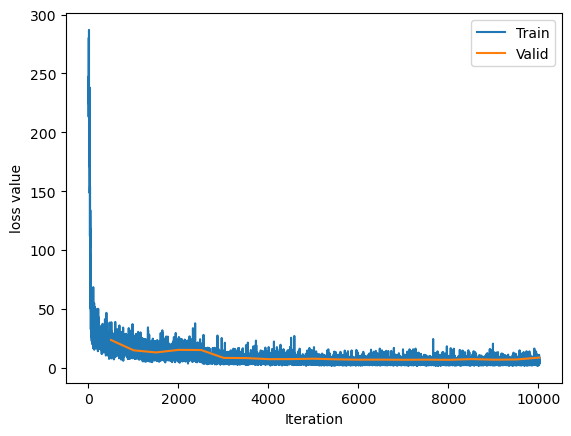

In [10]:
train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_dataloader)
valid_x = np.arange(1, len(valid_curve)+1) * train_iters*val_interval # 由于valid中记录的是epochloss，需要对记录点进行转换到iterations
valid_y = valid_curve

plt.plot(train_x, train_y, label='Train')
plt.plot(valid_x, valid_y, label='Valid')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()